# Convolutional Neural Networks

Now let's talk about how we can process images with neural networks. Usually, we're interested in classification in this context: Given an image and 1000 things it could be, tell me which one of those things it is.

If we want to use our MLPs, we can do this:
1. Load the image
2. Do some image processing to get a vector of features that describe the image (e.g., maybe we can rate how blurry the four quadrants of the image are, etc.)
3. Train an MLP to map that feature vector to whatever we want to classify.

That's well and good, but it requires (1) a lot of effort on the human engineers to figure out how to do good image processing, and (2) there's no guarantee that the features the human engineers pick are optimal for describing images.

In comes (2D) **convolutional neural networks** or CNNs for short.

## Convolution? In TWO dimensions?

Okay, you're probably good on what a neural network is. But what the heck does it mean for it to be convolutional?

We're not going to go into all of the math of 2D convolution, but let's give a quick example.

Recall that in 1D, convolving a discrete impulse response $h$ with a discrete time series signal is the exact same as "filtering" the time series by the filter whose impulse response is $h$.

The same filtering intuition applies in 2D.

In [1]:
from skimage import data  # we're going to use scikit-image for a sample image
import numpy as np
import scipy.ndimage as ndimage  # we're going to use scipy to do 2D convolution for us

sample_img = data.text()

Sample Image


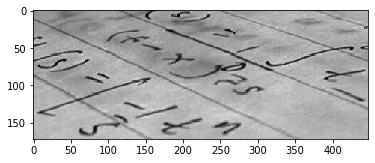

In [2]:
import matplotlib.pyplot as plt

print("Sample Image")
_ = plt.imshow(sample_img, cmap="gray")

Box Blur


(<matplotlib.image.AxesImage at 0x6225f4290>,
 <matplotlib.image.AxesImage at 0x6226f8390>)

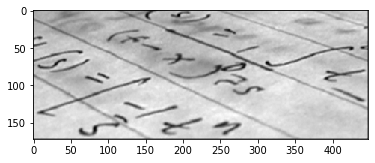

In [3]:

convolution_kernel = np.array(
    [[1, 1, 1],
     [1, 1, 1],
     [1, 1, 1]], dtype=np.float32)
convolution_kernel /= np.sum(convolution_kernel)
print("Box Blur")
output_img = ndimage.convolve(sample_img, convolution_kernel, mode="constant")
_, plt.imshow(output_img, cmap="gray")

Edge Detection


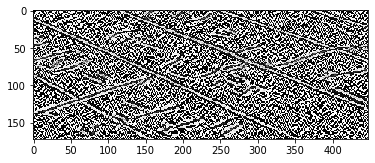

In [4]:
# convolution_kernel = np.array(
#     [[0, 1, 0],
#      [1,-4, 1],
#      [0, 1, 0]]
# , dtype=np.float32)
convolution_kernel = np.array(
    [[1, 0, -1],
     [0, 0, 0],
     [-1, 0, 1]], dtype=np.float32)


print("Edge Detection")
output_img = ndimage.convolve(sample_img, convolution_kernel, mode="constant")
_ = plt.imshow(output_img, cmap="gray")

These examples are maybe not the clearest. Wikipedia has a beautiful set of examples that I highly recommend looking at:

https://en.wikipedia.org/wiki/Kernel_(image_processing)#Details

## Example - CIFAR10

NOTE: This is mainly going to be copied from the following PyTorch example:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

with adjustments to make it more beginner-friendly.

### Data

We're going to use the CIFAR-10 dataset. It has 10 classes and the images are shaped 3 x 32 x 32 (RGB images, 32x32 pixels in size).

NOTE: Conventionally, deep learning libraries like PyTorch and TensorFlow prefer you to give your images as arrays with the color being the first dimension (i.e., *Channels Height Width* or *CHW*).

The Torchvision package makes it easy for us to get that dataset:

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
# torchvision loads files in the range [0, 1].
# This instantiates a function to (1) turn them into tensors
# and (2) subtract the "mean" of 0.5 from each color channel and divide the "std" of 0.5 from each color channel.
# I.e., usually you compute per-channel means and stds on your training set and normalize the image pixels.
# Here, they're being cheap and using the mean/std normalization to convert pixels to a range of [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


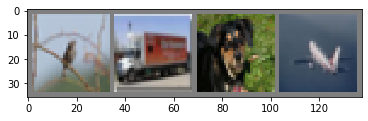

 bird truck   dog plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### Defining the Network

The overall flow of a CNN is this:
* Convolutional Block x about 5
* Collapse spatial dimensions
* MLP classifier

#### Convolutional Block

Convolve:

1. Given input image with N channels:
2. The convolutional layer has M filters (where $M \geq N$ almost always).
3. For each of the M filters:
    1. Apply the filter to each of the N input channels (convolution).
    2. Sum up the N output images pixel-wise across the channels (technically makes it cross-correlation, not convolution).
4. Stack up the resulting M "cross-correlation images" to make an output image with M channels.

Activate:

1. Apply a nonlinear function element-wise.

Rescale:

1. Somehow downsample the image. The most popular strategies are:
    1. MaxPooling: Divide the image up into a 2x2-pixel grid. For each 2x2 cell, take the maximum element. This cuts the spatial dimensions in half.
        1. Average pooling exists too, but you don't see it used in convolutional blocks very often.
    2. Strided convolution: E.g., give your kernel a width of 5 and then apply it on every OTHER pixel. Every pixel in the input image affects the output, and the output will be half the size.
    
    
That process repeats, though how many times depends on the size of the input image. For a 224x224 input image (by far the most common), it'll repeat around 5 times.

HIGHLY recommended reading (also beautiful animations) to reinforce everything I just said:
* (20ish minutes?) https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

Note that there's different flavors here. Sometimes people convolve several times in series, sometimes they make parallel convolutional blocks, etc. The convolutional block design is the major driving force behind new CNN standard architectures.

#### Collapsing Spatial Dimensions

After repeating the convolutional block enough times, the image gets to be pretty small (usually 4-8 pixels in the H and W dimensions) and we build up a large number $F$ of channels (usually 1024-4096 with 2048 being the most common).

Usually, the next step is to "merge" the spatial dimensions together so we're left with a $F$-dimensional **feature vector**.

Typically, for each feature channel, you simply average together the $4^2$-$8^2$ pixels.

This is the most common place you see average pooling. Sometimes this step is called **global average pooling**.

The other main way to merge the spatial dimensions is to "stack up" the $F$ channels so we're left with an, e.g., $4^2 \times F$-dimensional feature vector.

#### Fully Connected Layers

At this point, we just apply a standard neural network for classification like before, where the input is the feature vector. But the layers get all sorts of names like **dense layers**, **fully connected layers**, and, taken as a whole, the **bottleneck** or the **classifier**.

Note that you don't always see MLPs get used. The feature vector extraction (i.e., the convolutional section) is already nonlinear, so you don't need to beat a dead horse. You COULD just go from the $F$-dimensional feature vector to a vector with an element for each class with a linear layer and call it a day.

In [8]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        # Layer 1 modules
        # note that you must "pad" the image with "enough" 0's around the border
        # if you don't want the spatial size to change under convolution
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)  # (B, 3, 32, 32) -> (B, 6, 32, 32)
        self.actv1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # (B, 6, 16, 16) -> (B, 6, 16, 16)
        
        # Layer 2 modules
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2)  # (B, 6, 16, 16) -> (B, 16, 16, 16)
        self.actv2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # (B, 16, 16, 16) -> (B, 16, 8, 8)

        # at this point, we'll use the "stack up" method since F=16 is small.
        # We'll have an 8^2 times 16 dimensional feature vector to work with.
        
        # the bottleneck will be a 3-layer MLP
        
        # fully connected 1
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.actv_fc1 = nn.ReLU()
        
        # fully connected 2
        self.fc2 = nn.Linear(120, 84)
        self.actv_fc2 = nn.ReLU()
        
        # output layer
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # layer 1
        # x: (B, 3, 32, 32)
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.pool1(x)
        # x: (B, 6, 16, 16)
        
        # layer 2
        # x: (B, 6, 16, 16)
        x = self.conv2(x)
        x = self.actv2(x)
        x = self.pool2(x)
        # x: (B, 6, 8, 8)
        
        # collapse spatial dimensions
        # x: (B, 6, 8, 8)
        x = x.view(-1, 16 * 8 * 8)
        # x: (B, 16*8*8)
        
        # fully connected layers
        x = self.actv_fc1(self.fc1(x))  # (B, 16*8*8) -> (B, 120)
        x = self.actv_fc2(self.fc2(x))  # (B, 120) -> (B, 84)
        x = self.fc3(x)  # (B, 84) -> (B, num_classes)
        return x


net = Net()


It's important to note that the input size of the CNN is pretty much fixed. When you use global average pooling to collapse the spatial dimensions, you *could* use an arbitrary input size, but for classification that is very uncommon.

### Defining a Loss function and optimizer

In [9]:
# this is just like for a classification MLP
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

### Train the Network

In [10]:
import time

In [11]:
tic = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            toc = time.time()
            minutes, seconds = divmod(toc - tic, 60)
            print(f"[{int(minutes):2d}m{seconds:2.0f}s, epoch {epoch + 1}, iter {i+1:5d}] "
                  f"loss: {running_loss/2000:.3f}")
            running_loss = 0.0

print('Finished Training')


[ 0m 9s, epoch 1, iter  2000] loss: 2.017
[ 0m19s, epoch 1, iter  4000] loss: 1.764
[ 0m29s, epoch 1, iter  6000] loss: 1.666
[ 0m38s, epoch 1, iter  8000] loss: 1.582
[ 0m49s, epoch 1, iter 10000] loss: 1.511
[ 0m59s, epoch 1, iter 12000] loss: 1.501
[ 1m11s, epoch 2, iter  2000] loss: 1.457
[ 1m21s, epoch 2, iter  4000] loss: 1.418
[ 1m30s, epoch 2, iter  6000] loss: 1.386
[ 1m40s, epoch 2, iter  8000] loss: 1.364
[ 1m49s, epoch 2, iter 10000] loss: 1.351
[ 1m58s, epoch 2, iter 12000] loss: 1.366
Finished Training


### Saving the Model

When you're just running a bunch of training tests or demonstrating code, you probably don't want to bother saving the model.

However, I was once told that the whole point of all of this is to make models. If you're not saving your models, you're wasting time.

I bring this up now because that training took 2 minutes, which is the longest we've seen. Usually for long training (hours) you'll want to checkpoint the model during the training so you can easily resume the training if something were to go wrong.

More on saving and loading here: (1 min) https://pytorch.org/docs/stable/notes/serialization.html

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)  # the state dict is just the weights

And then to reload, I would do

In [13]:
loaded_net = Net()
loaded_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Note that I didn't have to do that *here*. I'm just illustrating.

### Testing the Model

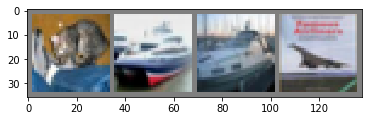

GroundTruth:    cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [15]:
outputs = net(images)


In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    cat   car  ship  ship


Looks pretty good.

Note that on this dataset, if we assume there are equal numbers of each class in the test set, then random chance would be 10%. So let's see how we did...

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 52 %


In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 51 %
Accuracy of   car : 58 %
Accuracy of  bird : 46 %
Accuracy of   cat : 44 %
Accuracy of  deer : 34 %
Accuracy of   dog : 33 %
Accuracy of  frog : 68 %
Accuracy of horse : 62 %
Accuracy of  ship : 73 %
Accuracy of truck : 55 %


## Takeaways

* You learned about 2D convolution.
* You learned the overall structure of a convolutional neural network: Convolve, nonlinearity, downsample, repeat til you switch to fully connected layers.
    * The essence of a convolutional neural network is the learned filters.
    * When used as classifiers, CNNs usually have fixed input sizes.
* You learned about saving and loading models in PyTorch.
    * In any framework you use, it's important to figure out how to do that.